## Introduction

We're now going to take a look at the drosha measurements and how to featurize them onto the graphs.

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
from pyprojroot import here
import pandas as pd
import os

df_bioc = pd.read_csv(here() / "data/df_bioc.csv", index_col=0)


There are a lot of columns in there, however, the ones we are most interested in are:

- `frac_avg`: Gives us the activity
- `dot_bracket`: Gives us the dot-bracket notation

Things that we may be interested in include:

- The `shannon_{pos}` series of columns, which gives us the shannon entropy of that particular position in the folded RNA.

Our goal here is to predict `frac_avg` (or some math transform of it) from the `dot_bracket` structure.
Our hypothesis here is that the `dot_bracket` structure represented as a graph
gives us sufficient information to predict `frac_avg` accurately;
alternatively, we might want to add in the shannon entropy,
as we found previously that it was visually\* correlated with RNA cleavage (`frac_avg`).


> \* by visually correlated, we refer to Fig. 2 of [our previously-published paper](https://www.sciencedirect.com/science/article/abs/pii/S1097276520307358).

In [3]:
from drosha_gnn.graph import to_networkx
import janitor

## Make graphs from dot-bracket

In [4]:
from scipy.special import logit
import jax.numpy as np

df = (
    df_bioc
    .query("frac_avg != 0")
    .join_apply(lambda row: to_networkx(row["dot_bracket"]), "graph")
    .transform_column("frac_avg", logit, "logit")
    .transform_column("frac_avg", lambda x: 1 -x, "minus_frac_avg")
    .transform_column("minus_frac_avg", logit, "minus_logit")
)
df.head()

entropy_columns = [c for c in df.columns if "shannon" in c]
def avg_entropy(row: pd.Series):
    total = 0
    count = 0
    data = row[row != -1]
    return data.mean()

avg_entropy = df[entropy_columns].join_apply(avg_entropy, "avg_entropy")["avg_entropy"]
df = df.add_column("avg_entropy", avg_entropy)

## Plot the ECDF of the target data

Check to see if there's any skew in here.

In [5]:
import numpy as onp

def ecdf(data):
    x = onp.sort(data)
    y = onp.arange(len(data)) / (len(data) + 1)
    return x, y

In [6]:
import jax.numpy as np

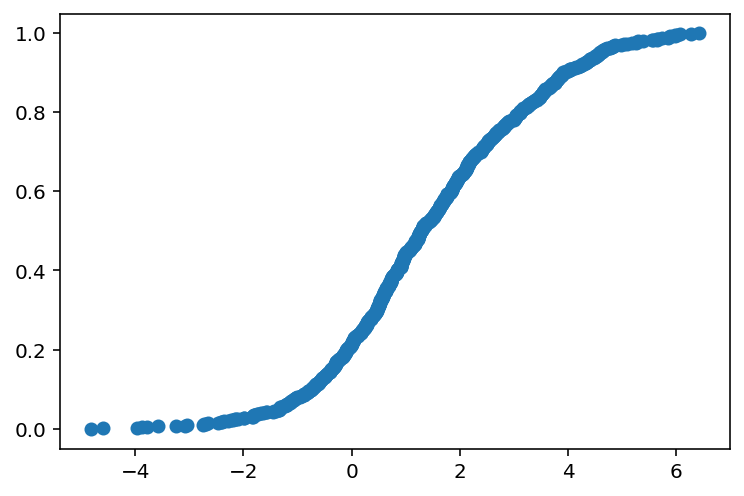

In [7]:
import matplotlib.pyplot as plt

x, y = ecdf(df["logit"].values)
plt.scatter(x, y)

We have a pretty even distribution of points here.

One thing that we'll definitely want to do is to regress on the logits,
so we'll have to transform the `frac_avg` column to logit space instead.

We'll also need to annotate each node on the graph with its nucleotide identifier.

In [8]:
graphs = df["graph"].to_dict()

## Annotate nucleotide and entropy

In [9]:
from drosha_gnn import annotate

In [10]:
def get_entropy_vector(df, row):
    r = df.loc[row]
    entropy_cols = [c for c in df.columns if "shannon" in c]
    return r[entropy_cols].values

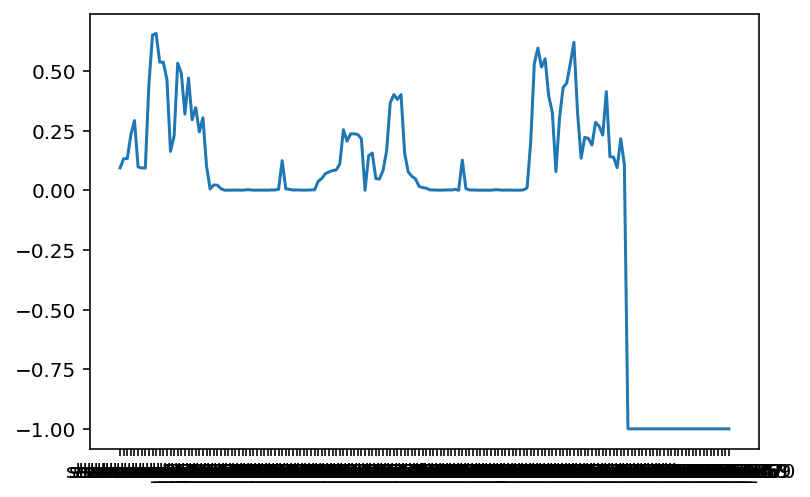

In [11]:
plt.plot(df.loc[760].loc[[c for c in df.columns if "shannon" in c]])

In [12]:
from tqdm.auto import tqdm
for idx, g in tqdm(graphs.items()):
    seq = df.loc[idx]["seq"]
    g = annotate.node_nucleotide(g, seq)

    entropy_vec = get_entropy_vector(df, idx)
    g = annotate.node_entropy(g, entropy_vec)
    graphs[idx] = g

  0%|          | 0/847 [00:00<?, ?it/s]

## Transformation to graph data structures

We're now going to make the feature matrix and adjacency matrix for each graph.
The key here is that we have to pad it to a particular size
in order for the operations to work correctly.

In [13]:
from jax import jit

@jit
def prep_feats(F, size):
    # F is of shape (n_nodes, n_feats)
    return np.pad(
        F,
        [
            (0, size - F.shape[0]),
            (0, 0)
        ],
    )


@jit
def prep_adjs(A, size):
    # A is of shape (n_nodes, n_nodes)
    return np.pad(
        A,
        [
            (0, size-A.shape[0]),
            (0, size-A.shape[0]),
        ],
    )

In [14]:
largest_graph_size = max(len(g) for g in graphs.values())

In [15]:
def feat_matrix(G):
    """Return feature matrix of a graph.
    
    - `nucleotide_idx` is nothing more than an indexer for node embeddings.
    - `entropy` is the entropy of the node itself.
    """
    feats = []
    for n, d in G.nodes(data=True):
        feat_vect = np.array([d["nucleotide_idx"], d["entropy"]])
        feats.append(feat_vect)
    feats = np.stack(feats)
    return feats

## Feature matrices

In [16]:
from tqdm.auto import tqdm
feat_matrices = dict()
for idx, graph in tqdm(graphs.items()):
    feat_matrices[idx] = prep_feats(feat_matrix(graph), largest_graph_size)

  0%|          | 0/847 [00:00<?, ?it/s]

## Adjacency matrices

In [17]:
import networkx as nx
adj_matrices = dict()
for idx, graph in tqdm(graphs.items()):
    adj_matrices[idx] = prep_adjs(np.array(nx.adjacency_matrix(graph).todense()), largest_graph_size)

  0%|          | 0/847 [00:00<?, ?it/s]

In [18]:
pd.Series(adj_matrices, name="adj")

760    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
636    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
475    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
467    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
62     [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                             ...                        
664    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
763    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
696    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
302    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
725    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: adj, Length: 847, dtype: object

In [19]:
pd.Series(feat_matrices, name="feats")

760    [[3.0, 0.09332664], [4.0, 0.13214985], [1.0, 0...
636    [[3.0, 0.03202673], [4.0, 0.04849543], [1.0, 0...
475    [[3.0, 0.1934112], [4.0, 0.21741793], [1.0, 0....
467    [[3.0, 0.061604444], [4.0, 0.07143515], [1.0, ...
62     [[3.0, 0.12407032], [4.0, 0.13753994], [1.0, 0...
                             ...                        
664    [[3.0, 0.0781185], [4.0, 0.07724453], [1.0, 0....
763    [[3.0, 0.06729441], [4.0, 0.06746953], [1.0, 0...
696    [[3.0, 0.018253764], [4.0, 0.018221803], [1.0,...
302    [[3.0, 0.27845892], [4.0, 0.30132464], [1.0, 0...
725    [[3.0, 0.070539854], [4.0, 0.069980554], [1.0,...
Name: feats, Length: 847, dtype: object

## Graph matrices

The adjacency and feature matrices put together.

In [20]:
graph_matrices = dict()
for (idx, adj), (idx2, feat) in zip(adj_matrices.items(), feat_matrices.items()):
    graph_matrices[idx] = np.concatenate([adj, feat], axis=1)

In [74]:
with open(here() / "data/graph_matrices.pkl", "wb") as f:
    pkl.dump(graph_matrices, f)

In [79]:
len(graph_matrices.keys())

868

In [77]:
len(graph_matrices.keys())

847

Now, we can start designing a graph attention network to do this!

Firstly, we need a node embedding layer. 
For this, we will borrow inspiration from the language modelling world.
Our "vocabulary" is the letters "AUGC",
so we'll use a learnable embedding for each letter.
Every node feature vector's first slot is dedicated to an integer value
that we can use to index into the embedding vector.
We'll make the embedding vector length 256,
just for funzies.

In [21]:
from jax import random

rng = random.PRNGKey(99)

When it comes to GNN operations,
some involve the feature matrix only,
others involve the adjacency matrix only,
and yet others involve both the adjacency and feature matrices.

To simplify the representation of a graph,
let's consider the case where we have only a 2D matrix.
It is of size (num_nodes, num_nodes + num_features).
What do they semantically mean?

- The (num_nodes, num_nodes) portion (left side of the matrix) is the adjacency matrix.
- The (num_nodes, num_features) portion (right side of the matrix) is the feature matrix.

In each step, we can accept the entire thing as one piece, and then split accordingly.

Let's call this matrix the "graph matrix"

Because one graph is one sample, its shape, then, is defined as `(num_nodes, num_nodes + num_features)`.

In [22]:
from jax import random

## RNA Graph Embedding

Embed AUGC nodes in learnable high dim space.

In [23]:
from drosha_gnn.layers import RnaGraphEmbedding

In [24]:
init_fun, apply_fun = RnaGraphEmbedding(num_nodes=170, embedding_size=256)
output_shape, params = init_fun(rng, input_shape=(170, 2))

out = apply_fun(params, (graph_matrices[763]))
# out[0].shape, out[1].shape
out.shape

(170, 426)

## Node Feature Extractor

We also need a layer that simply extracts out the rest of the node features.

In [25]:
from drosha_gnn.layers import NodeFeatureExtractor

init_fun, apply_fun = NodeFeatureExtractor(num_nodes=170)
_, params = init_fun(rng, (170, 2))
out = apply_fun(params, (graph_matrices[763]))
out.shape, _

((170, 171), (170, 171))

Now we can do the fan-out operation.

In [26]:
from jax.experimental import stax

In [27]:
node_featurization = stax.serial(
    stax.FanOut(2),
    stax.parallel(
        RnaGraphEmbedding(num_nodes=170, embedding_size=256),
        NodeFeatureExtractor(num_nodes=170),
    ),
)

In [28]:
# Test-drive
init_fun, apply_fun = node_featurization
output_shape, params = init_fun(rng, input_shape=(170, 2,))

inputs = apply_fun(params, (graph_matrices[763]))
output_shape

((170, 426), (170, 171))

## Graph Fan-in Concat

In [29]:
from jax.tree_util import tree_map
from functools import partial
from drosha_gnn.layers import select_adj, select_feats, GraphFanInConcat

init_fun, apply_fun = stax.serial(
    stax.FanOut(2),
    stax.parallel(
        RnaGraphEmbedding(num_nodes=170, embedding_size=256),
        NodeFeatureExtractor(num_nodes=170),
    ),
    GraphFanInConcat(num_nodes=170)
)
output_shape, params = init_fun(rng, input_shape=(170, 2))
out = apply_fun(params, graph_matrices[763])

## Graph Attention Layer aka attentive adjacency matrix layer

After that, we do the Graph attention layer.
I've written this layer a few times,
but I'd like to do this layer in a fashion
that makes sense for this problem.

The Graph attention layer accepts in a graph matrix.
It then computes a node-by-node similarity matrix based on the node information.


In [30]:
from functools import partial
from jax import vmap

In [31]:
from jax import nn
from drosha_gnn.layers import AttentiveMessagePassingLayer, GetGraphAdjAttentionMatrix

## Attentive graph summation a.k.a. node attention

Now, we need an attentive graph summation layer.

If we define attention as just "sample driven, fancy ways of calculating linear weighting...",
then we can use a neural network to calculate weights per sample.

The input is the graph matrix of shape `(num_nodes, num_nodes + num_feats)`.
Inside this function, we take the matrix and do a neural network forward pass
to produce a vector that is of length `(num_nodes,)`,
which we can call the "attentive weights".
Finally, we take feature matrix portion of the graph matrix
and dot product it against the attentive weights
to arrive at the summed up vector
to give effectively a graph-level vector.

In [32]:
def compute_node_attention_weights(params, feats):
    w1, b1, w2, b2 = params
    a1 = np.tanh(np.dot(feats, w1) + b1)
    a2 = nn.relu(np.dot(a1, w2) + b2)
    return np.squeeze(a2)

In [33]:
from drosha_gnn.layers import AttentiveGraphSummation, GetNodeAttention

We should make sure that given two different graphs inputs, the node attention weights that are computed are indeed different.

## GNN definition

In [34]:
from drosha_gnn.models import AttentionEverywhereGNN

init_fun, apply_fun = AttentionEverywhereGNN(170)

output_shape, params = init_fun(rng, input_shape=(170, 2))
out = apply_fun(params, graph_matrices[763])

## Graph Adjacency attention extractor

In [35]:
from drosha_gnn.models import GraphAdjacencyAttention, GraphNodeAttention


## Train neural network


We can now train the model!

## Get train test split

In [36]:
# X = np.stack(pd.Series(graph_matrices).values)
# y = np.stack(df["logit"].values).reshape(-1, 1)

In [37]:
from drosha_gnn.training import train_test_split

train_idxs, test_idxs = train_test_split(rng, df)
graph_series = pd.Series(graph_matrices)
X_train = np.stack(graph_series[train_idxs].values)
X_test = np.stack(graph_series[test_idxs].values)
y_train = df.loc[train_idxs, "logit"].values.reshape(-1, 1)
y_test = df.loc[test_idxs, "logit"].values.reshape(-1, 1)

[752 305 323 709 801 779  21  57 338  17   6 759 695 483 156 788 364 495
 606 628 180 601 787 832 809 119 529 687 642 479 868 582 434 730 650 649
 265 184 146 247 437 286 711 425 413 795 690 714 441 517 333 381 325 389
 207 251 526 487 500 465 315 620 563 777 664 362   3 742 744 299 462 859
 811 294 179 122 407 646 567 820 355 550 602 134 324 202 432 814 118  80
 673 275 458  27 206 452 171 377 675 187 148 592  83 414 618 194 370  11
 257 215 421  19 322 604 341  82  20 195 454 682   9 670 128 335 274 428
 346  39  49 172 230 492 398 190  81  70 235 511 845  66 372 233 718 720
 743 790 409 747 373 652 271 534 691 846 225  54 657 169  38 502 185 596
 741  78  64 127 556 191 353  89 226 786 330 680 693 659 395 857 427 328
 473 374 570 426 496 149 791 850 380 167 793 614 178 342 475 666 219 708
 192 812 712 647   8 295 401 508 200 318 599 672 838 293 516 726 559 307
 754 519 384 727 351 332 303 212 152 829 153 472 144 639 263 254 329 387
 379 692 218 193  87 258 561 610 580 481 835 276 45

In [38]:
from jax import value_and_grad, vmap
from jax import jit

## Training loop
def mse(y_true: np.array, y_pred: np.array):
    return np.mean(np.power(y_true - y_pred, 2))


@jit
def mseloss(params, model, X, y):
    """MSE loss."""
    y_pred = vmap(partial(model, params))(X)
    return mse(y, y_pred)


dmseloss = jit(value_and_grad(mseloss))

In [39]:
from jax.tree_util import Partial
init_fun, model = AttentionEverywhereGNN(170)
model = Partial(model)
_, params = init_fun(rng, input_shape=(170, 2))

In [40]:
mseloss(params, model, X_test, y_test), mseloss(params, model, X_train, y_train)

(DeviceArray(5.1924844, dtype=float32), DeviceArray(5.7466187, dtype=float32))

## Training Loop

In [41]:
from jax.experimental.optimizers import adam
opt_init, opt_update, opt_get_params = adam(5e-3)
state = opt_init(params)
opt_get_params = jit(opt_get_params)


@jit
def step(i, state, X, y):
    params = opt_get_params(state)
    l, g = dmseloss(params, model, X, y)
    state = opt_update(i, g, state)
    return l, state

import pickle as pkl
losses_train = []
losses_test = []
iterator = tqdm(range(200), desc="Training Loss")
states = []
for i in iterator:
    l_train, state = step(i, state, X_train, y_train)
    losses_train.append(l_train)
    
    params = opt_get_params(state)
    l_test = mseloss(params, model, X_test, y_test)
    losses_test.append(l_test)
    states.append(state)

    iterator.set_description(f"Training Loss: {l_train:.2f}, Test Loss: {l_test:.2f}")
    with open(f"weights/iter_{i}.pkl", "wb") as f:
        weights_to_dump = opt_get_params(state)
        pkl.dump(weights_to_dump, f)

Training Loss:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

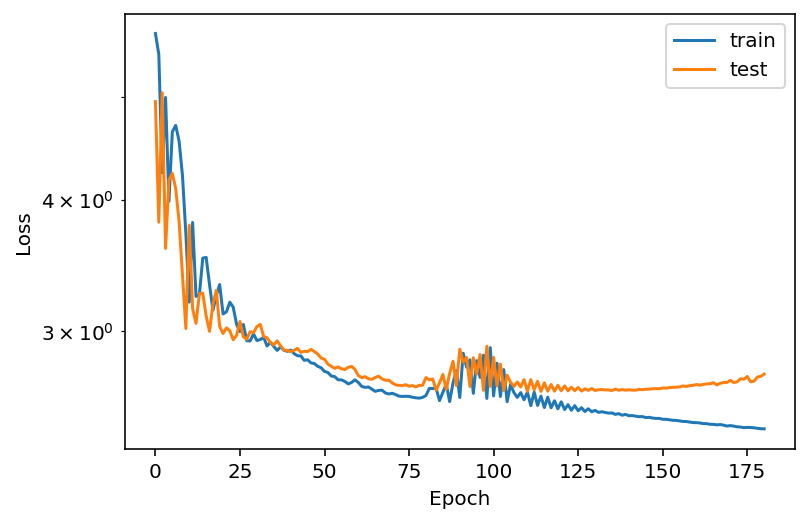

In [42]:
import matplotlib.pyplot as plt

plt.plot(losses_train, label="train")
plt.plot(losses_test, label="test")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Pick out the snapshot weights that we want to use.

In [43]:
wanted_epoch = np.argmin(np.array(losses_test))
opt_params = opt_get_params(states[wanted_epoch])
preds_train = vmap(partial(model, opt_params))(X_train)
preds_test = vmap(partial(model, opt_params))(X_test)

In [44]:
wanted_epoch

DeviceArray(114, dtype=int32)

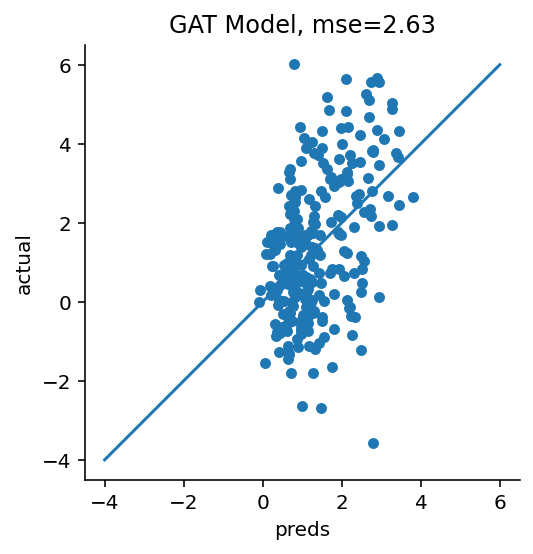

In [45]:
import seaborn as sns

train_compare = pd.DataFrame({"preds": preds_train.squeeze(), "actual": y_train.squeeze()})
test_compare = pd.DataFrame({"preds": preds_test.squeeze(), "actual": y_test.squeeze()})

test_compare.plot(kind="scatter", x="preds", y="actual")
plt.plot([-4, 6], [-4, 6])
plt.gca().set_aspect("equal")
plt.title(f"GAT Model, mse={mse(preds_test.squeeze(), y_test.squeeze()):.2f}")
sns.despine()

In [46]:
from sklearn.metrics import explained_variance_score as evs, mean_squared_error as mse

mse(preds_test.squeeze(), y_test.squeeze()), mse(preds_train.squeeze(), y_train.squeeze())

(2.6319365203900977, 2.540869927913989)

In [47]:
evs(preds_test.squeeze(), y_test.squeeze()), evs(preds_train.squeeze(), y_train.squeeze())

(-2.7403577549732425, -1.8953339330322332)

In [48]:
def get_k_est_graphs(n: int, lowest=False, training=True):
    """Get the highest N or lowest N graphs.
    
    Returns a pandas series with the networkx graph objects.
    """
    idxs = test_idxs
    if training:
        idxs = train_idxs
    
    k_est_graphs = df.loc[idxs].sort_values("frac_avg", ascending=lowest).head(n)["graph"]
    return k_est_graphs

<AxesSubplot:>

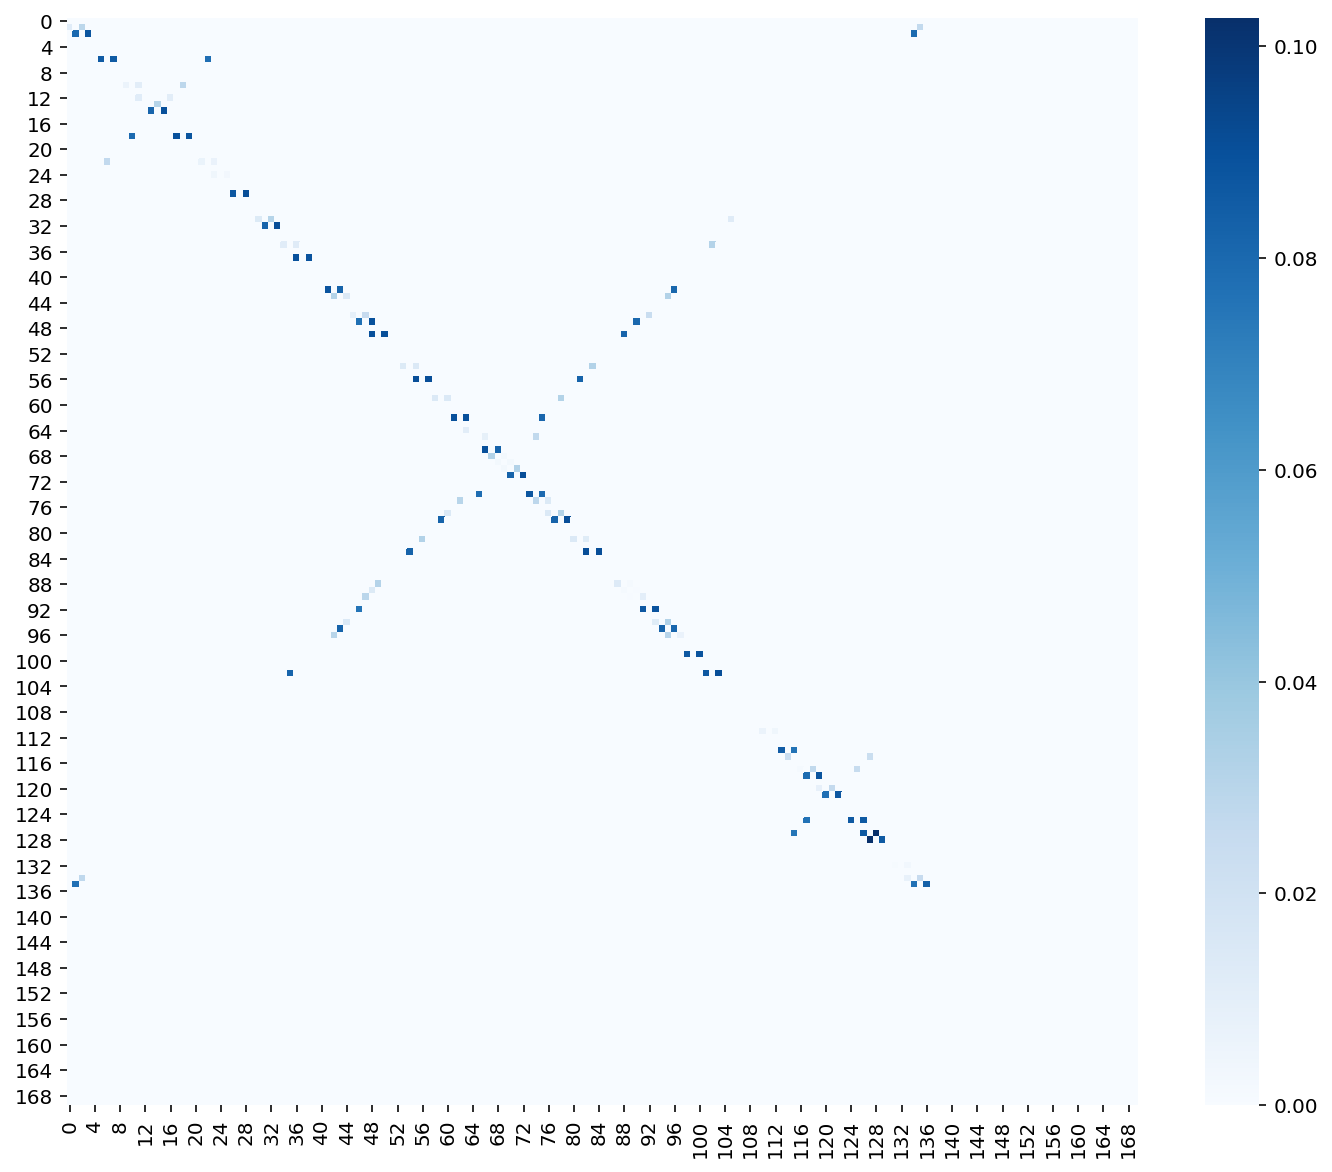

In [49]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm

## Test drive the graph adjacency attention layer
_, graph_attn_apply = GraphAdjacencyAttention(num_nodes=170)
graph_attn_apply = jit(graph_attn_apply)
graph_attn_params = opt_params[0:4]
hm = graph_attn_apply(graph_attn_params, graph_series[231])
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(hm, cmap="Blues")

In [50]:
n_graphs = 20
lowest_graphs = get_k_est_graphs(n_graphs, lowest=True)
highest_graphs = get_k_est_graphs(n_graphs, lowest=False)

## Adjacency Attention relationship with target value

In [51]:
def avg_attention(idx):
    g = graph_series[idx]
    hm = graph_attn_apply(graph_attn_params, g)
    num_nonzero = len(np.where(hm != 0)[0])
    return hm.sum() / num_nonzero

avg_attn = []
for idx in tqdm(graph_series.index):
    g = graph_series[idx]
    hm = graph_attn_apply(graph_attn_params, g)
    num_nonzero = len(np.where(hm != 0)[0])
    avg_attention = hm.sum() / num_nonzero
    
    # Annotate each edge with edge attention.
    for u, v in graphs[idx].edges():
        graphs[idx].edges[u, v]["attention"] = float(hm[u, v])
    avg_attn.append(avg_attention)

  0%|          | 0/847 [00:00<?, ?it/s]

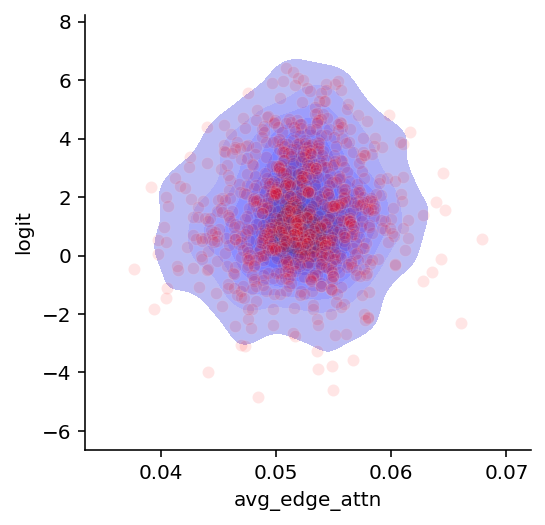

In [52]:
attention_df = (
    pd.DataFrame(
        {
            "avg_edge_attn": avg_attn, 
            "logit": df["logit"]
        }
    )
    .change_type("avg_edge_attn", float)
)

fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(data=attention_df, x="avg_edge_attn", y="logit", fill=True, color="blue")
sns.scatterplot(data=attention_df, x="avg_edge_attn", y="logit", alpha=0.1, color="red")
sns.despine()

Apparently _some_ kind of relationship between the average attention points given and the target values.

## Attention in the non-backbone edges

In [53]:
edge_attentions = dict()
for idx in tqdm(graph_series.index):
    edge_attentions[idx] = graph_attn_apply(graph_attn_params, graph_series[idx])
    edge_attentions = pd.Series(edge_attentions)

  0%|          | 0/847 [00:00<?, ?it/s]

## How does attention density along the non-backbone edges look like?

Attention density is the total sum of attentions across the non-backbone edges normalized by the number of non-backbone edges.
Backbone edges are always sequential. In the attention adjacency matrix, they will show up as off-by-one diagonals.
We just have to remove those from the attention matrix.

In [54]:
from nxviz.utils import edge_table
import janitor


mean_nonbackbone_attn = dict()
for idx in tqdm(graphs.keys()):
    g = graphs[idx]
    mean_attn = (
        edge_table(g)
        .join_apply(lambda row: abs(row["source"] - row["target"]) == 1, "adjacent")
        .query("~adjacent")
        .mean()["attention"]
    )
    mean_nonbackbone_attn[idx] = mean_attn

/home/ericmjl/anaconda/envs/drosha-gnn/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.0 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.6.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


  0%|          | 0/847 [00:00<?, ?it/s]

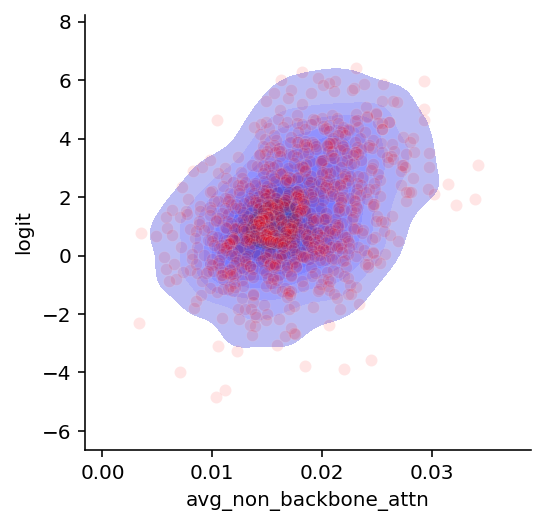

In [55]:
nonbb_attention_df = (
    pd.DataFrame(
        {
            "avg_non_backbone_attn": pd.Series(mean_nonbackbone_attn), 
            "logit": df["logit"]
        }
    )
    .change_type("avg_non_backbone_attn", float)
)

fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(x="avg_non_backbone_attn", y="logit", data=nonbb_attention_df, fill=True, color="blue")
sns.scatterplot(x="avg_non_backbone_attn", y="logit", data=nonbb_attention_df, alpha=0.1, color="red")
sns.despine()

## Node Attention

Now annotate node attention onto the graphs' nodes.

In [57]:
_, node_attention_apply = GraphNodeAttention(num_nodes=170)
node_attention_apply = jit(node_attention_apply)

for idx, g in tqdm(graphs.items()):
    for i, (n, d) in enumerate(g.nodes(data=True)):
        attn_scores = node_attention_apply(opt_params, graph_series.loc[idx]).squeeze()
        g.nodes[n]['attention'] = float(attn_scores[i])

  0%|          | 0/847 [00:00<?, ?it/s]

## Plot node attention alongside edge attention

In [58]:
import matplotlib as mpl
import matplotlib.cm as cm
import nxviz as nv
from nxviz import highlights

0it [00:00, ?it/s]

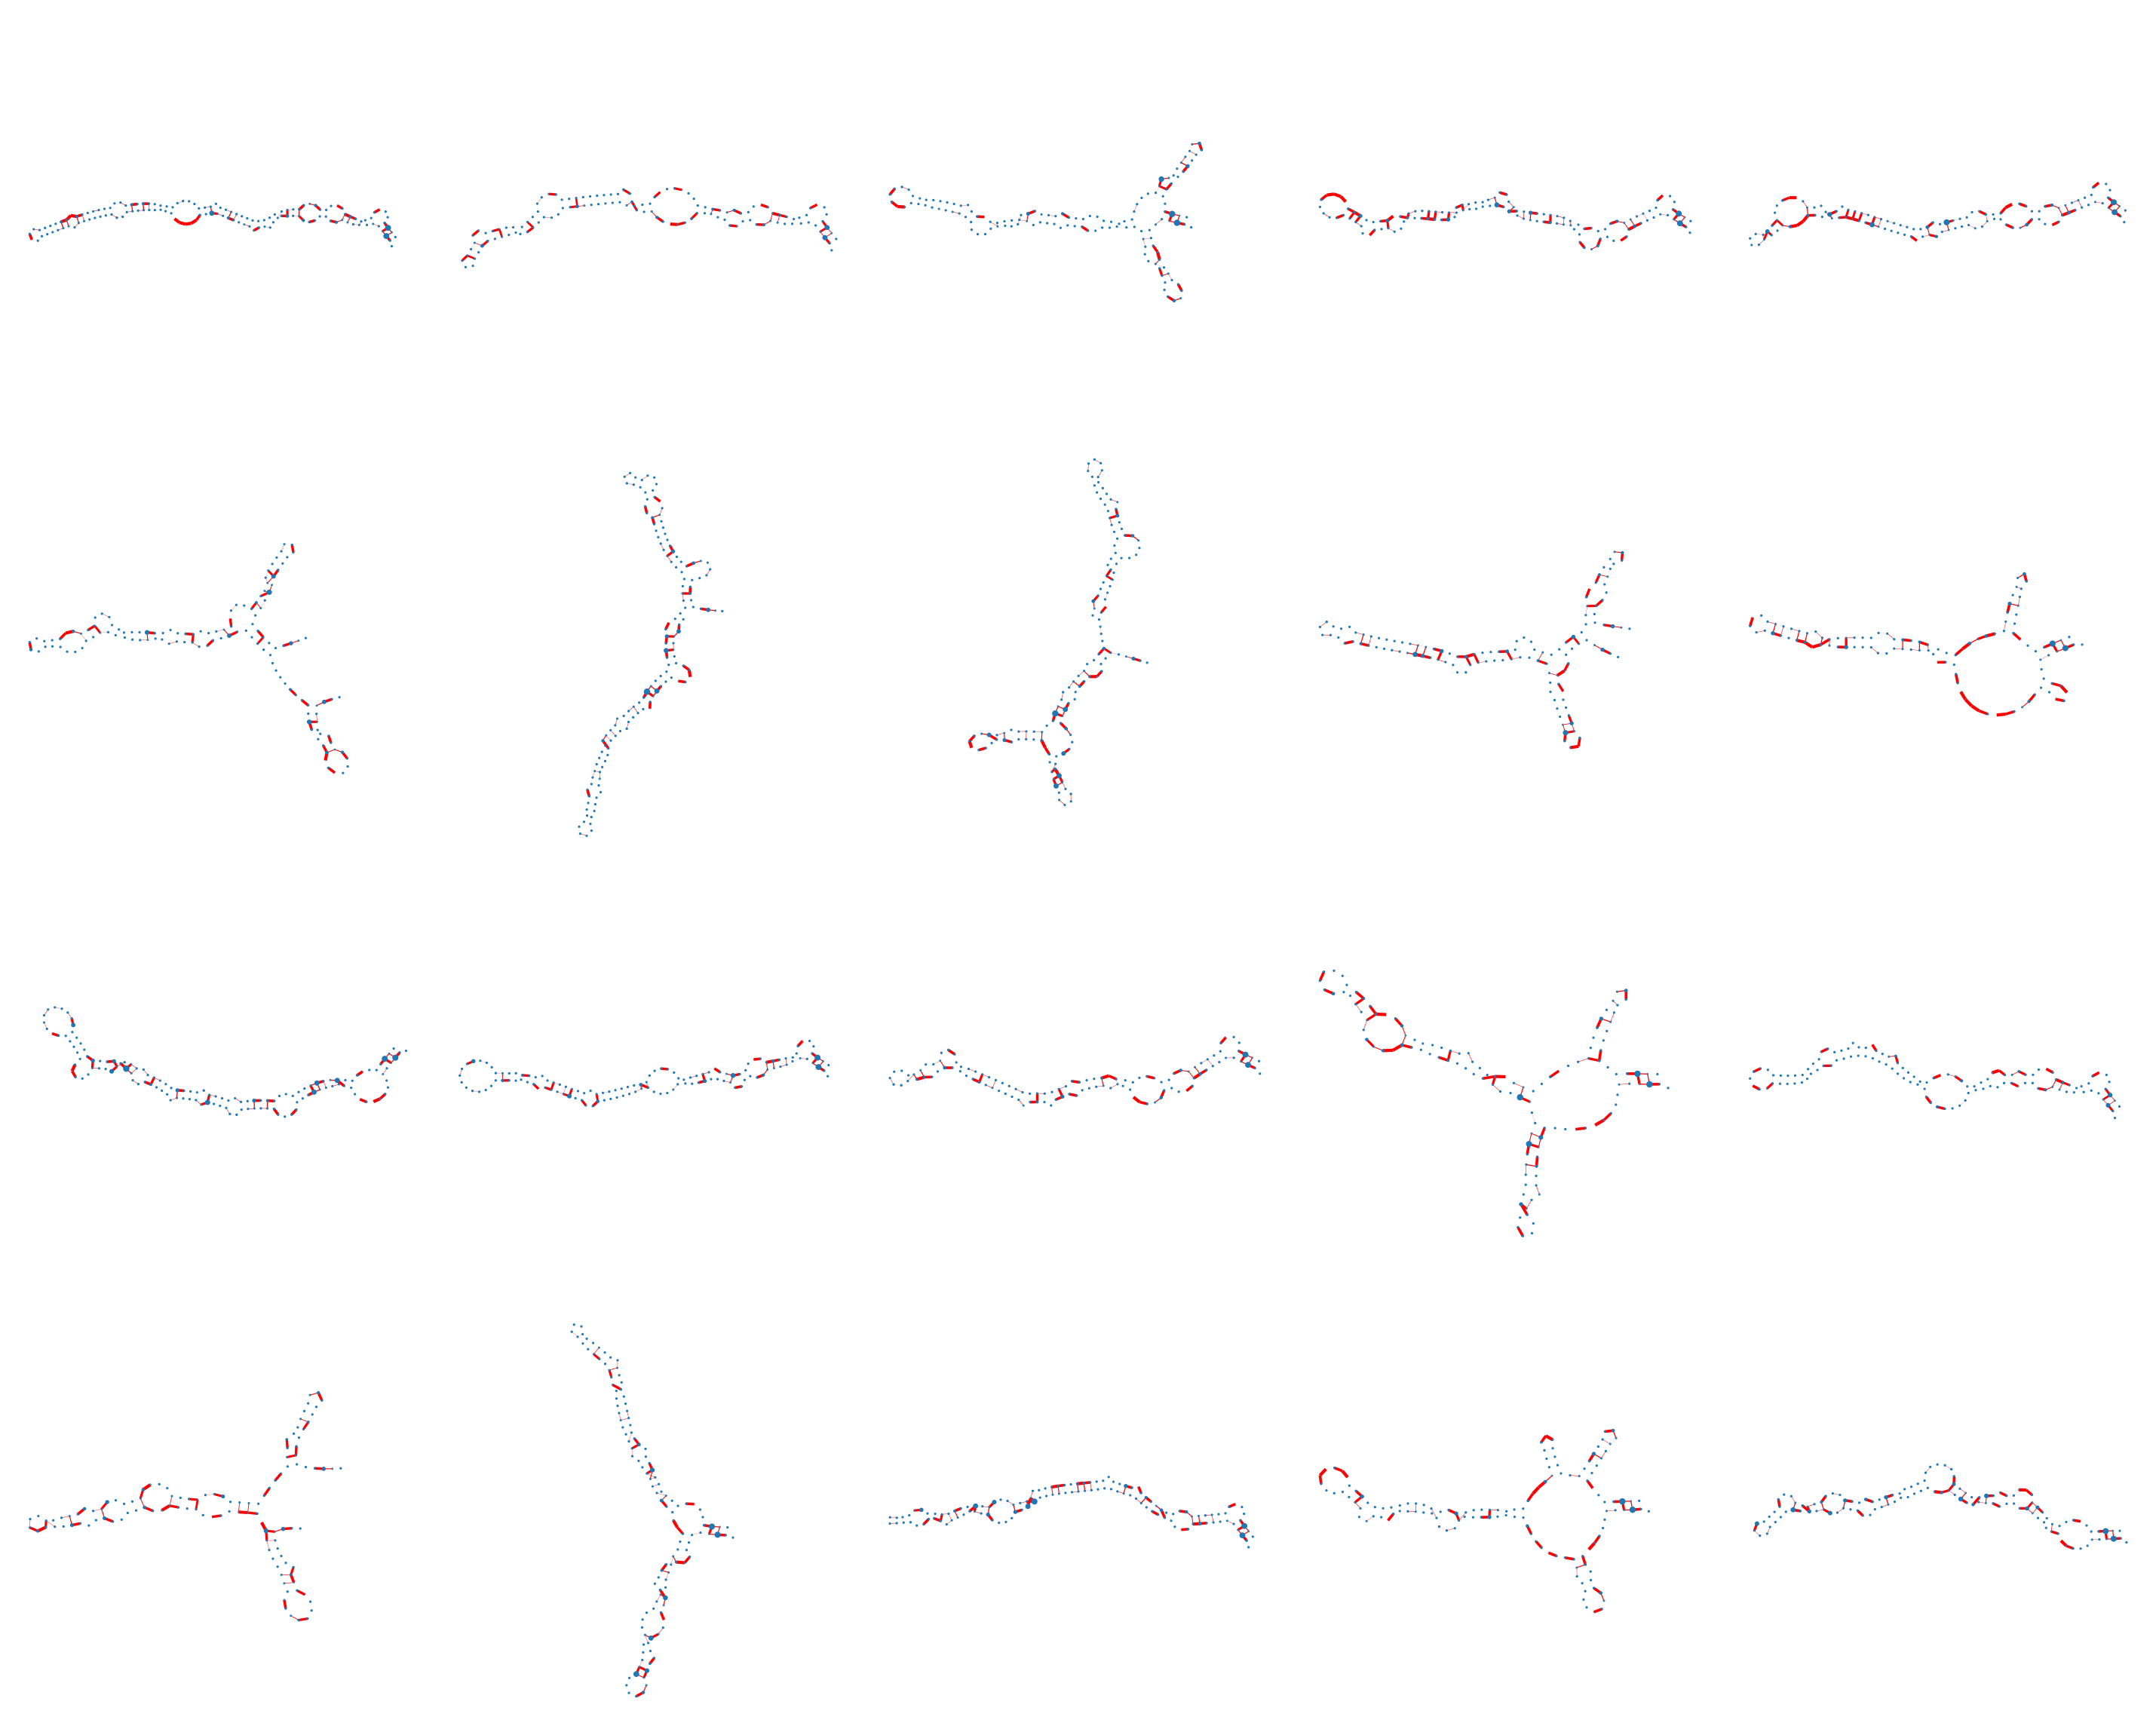

In [59]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from nxviz.plots import despine, aspect_equal

ax_dim = 4  # inches
n_rows = 4
n_cols = 5

fig, axes = plt.subplots(
    figsize=(n_cols * ax_dim, n_rows * ax_dim), 
    ncols=n_cols, 
    nrows=n_rows, 
    sharex=True, 
    sharey=True
)
node_size_scale = 15
node_size_power = 2.5

# Plot the lowest graphs
for i, idx in tqdm(enumerate(lowest_graphs.index)):
    plt.sca(axes.flatten()[i])
    g = graphs[idx]
    edge_width = np.array([d["attention"] for u, v, d in g.edges(data=True)]) * 20
    node_size = np.array([d["attention"] for n, d in g.nodes(data=True)])**node_size_power * node_size_scale
    pos = nx.kamada_kawai_layout(g)
    nx.draw_networkx_nodes(g, pos, node_size=node_size)
    nx.draw_networkx_edges(g, pos, width=edge_width, edge_color="red", edge_cmap="bwr")
    despine()
    aspect_equal()
plt.tight_layout()

0it [00:00, ?it/s]

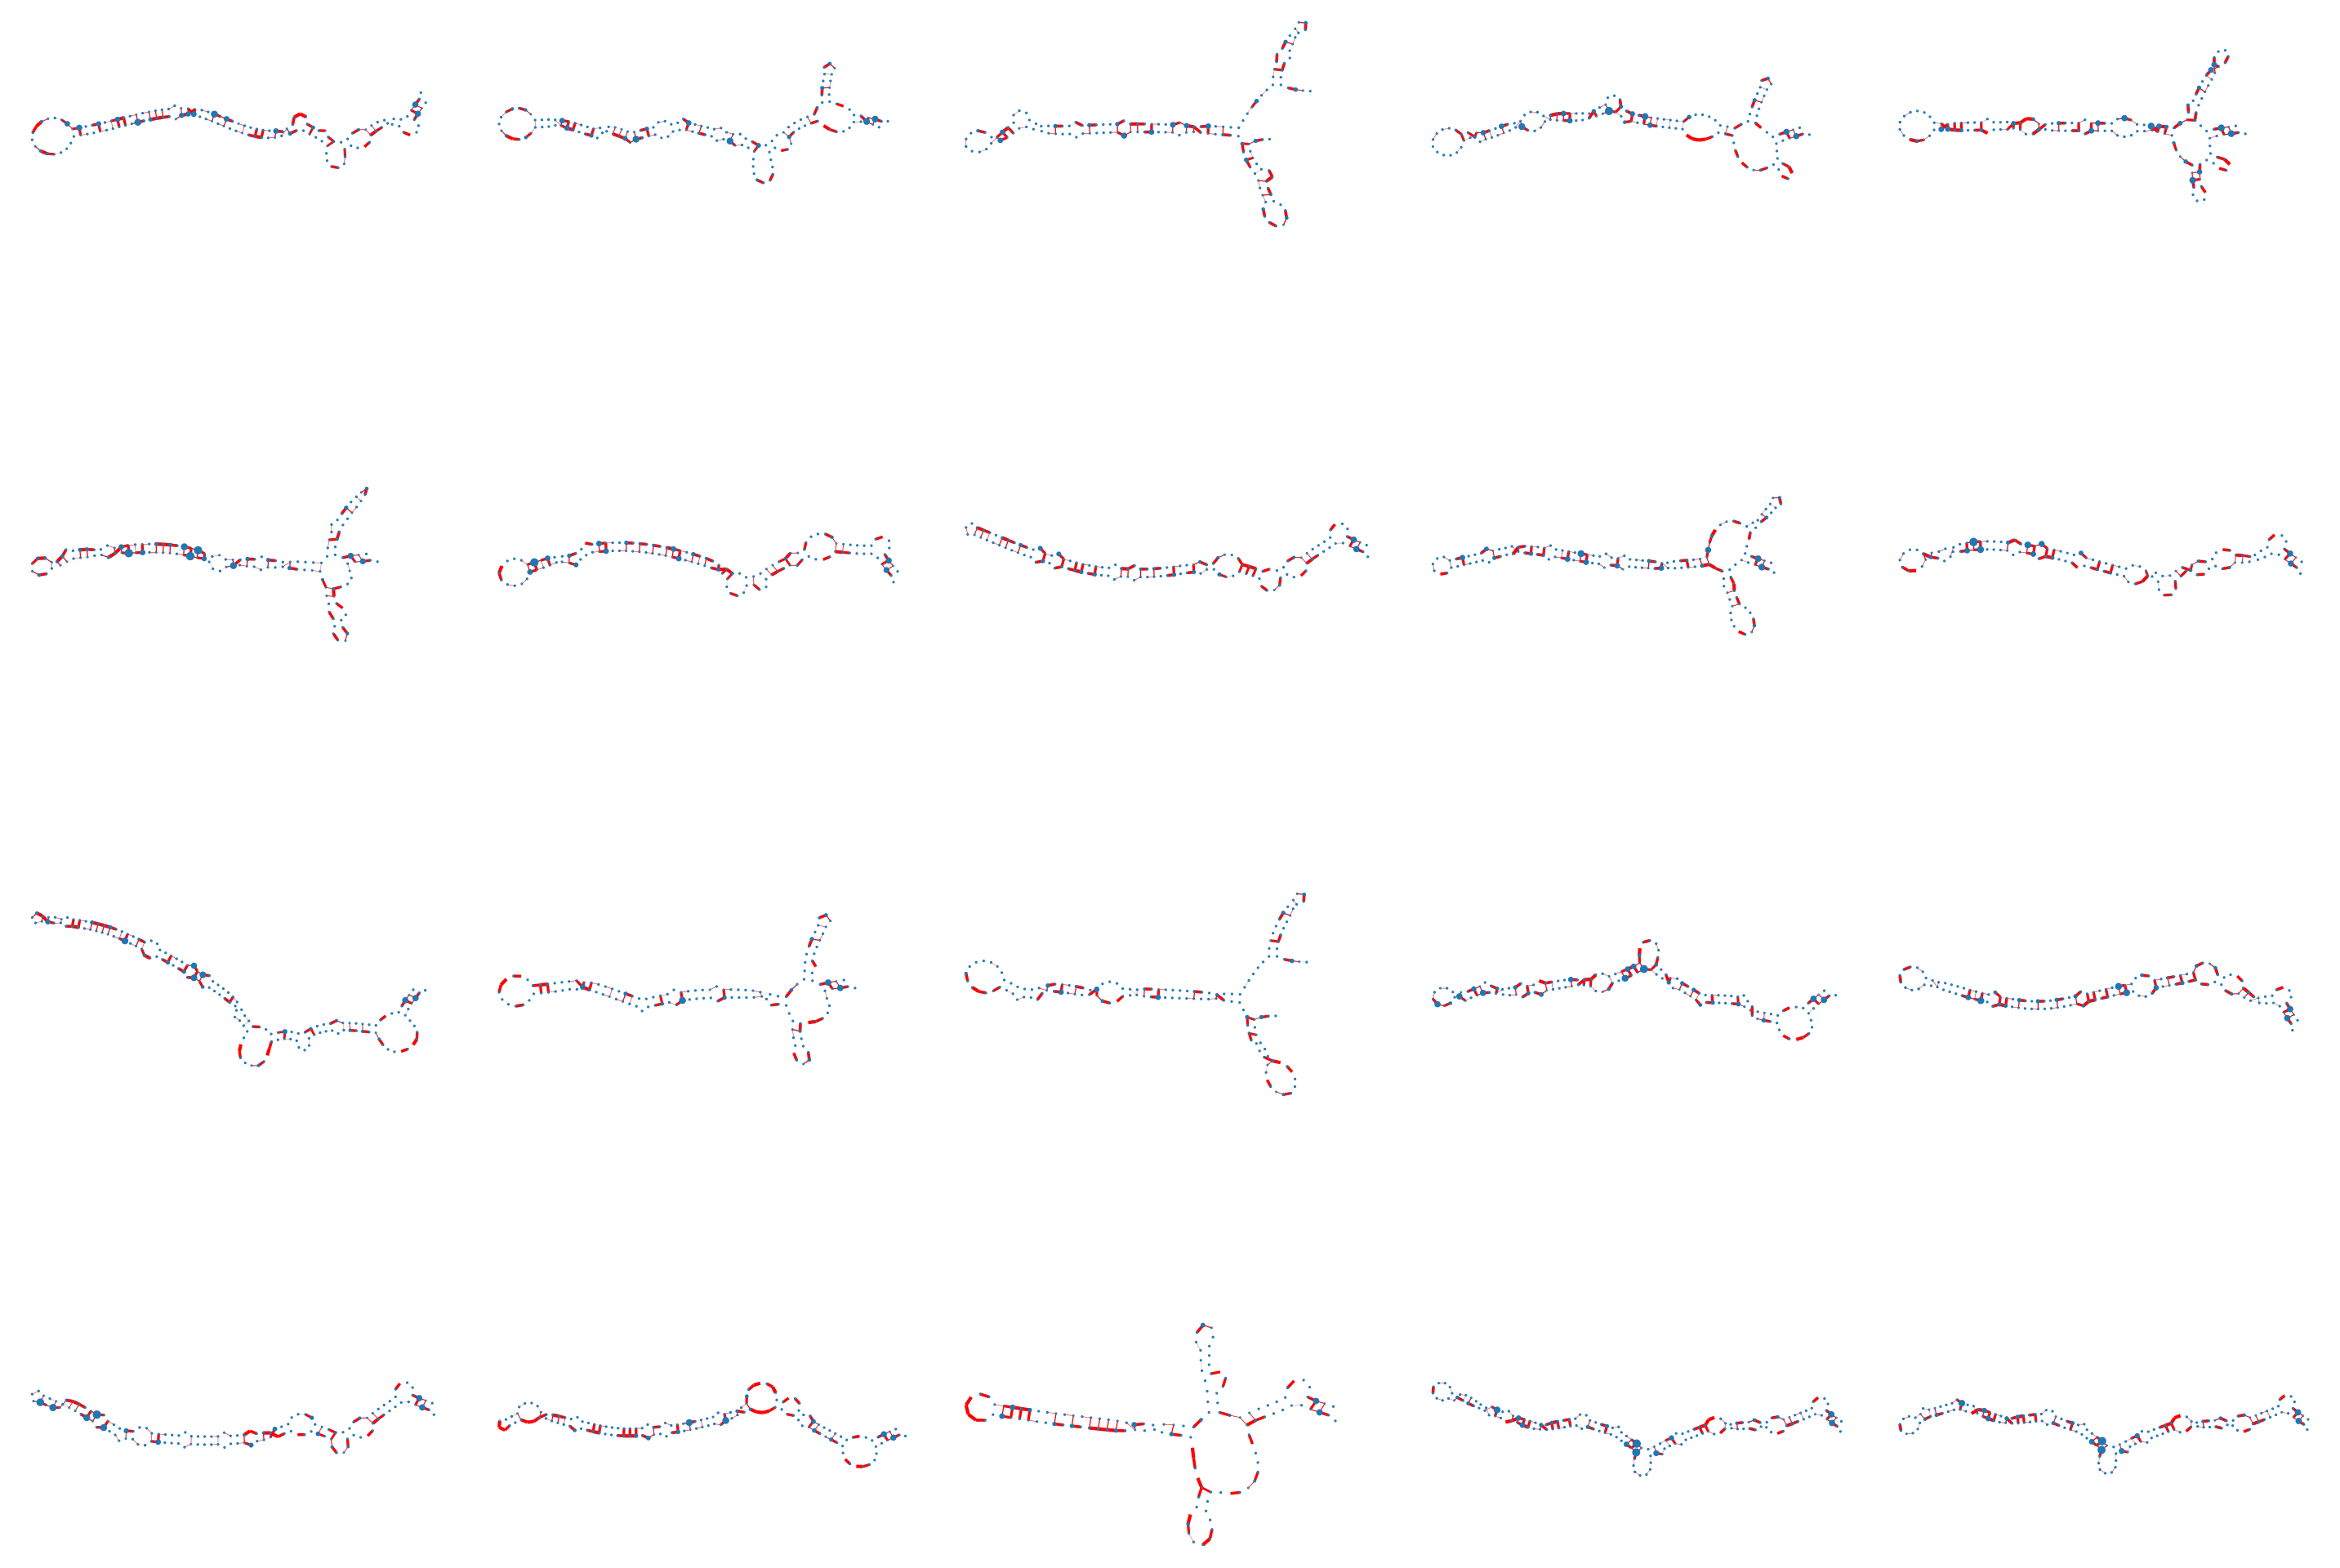

In [60]:
from nxviz.plots import aspect_equal, despine
fig, axes = plt.subplots(
    figsize=(n_cols * ax_dim, n_rows * ax_dim), 
    ncols=n_cols, 
    nrows=n_rows, 
    sharex=True, 
    sharey=True
)

node_size_scale = 15
node_size_power = 2.5


# Plot the highest graphs
for i, idx in tqdm(enumerate(highest_graphs.index)):
    plt.sca(axes.flatten()[i])
    g = graphs[idx]
    edge_width = np.array([d["attention"] for u, v, d in g.edges(data=True)]) * 20
    node_size = np.array([d["attention"] for n, d in g.nodes(data=True)])**node_size_power * node_size_scale
    pos = nx.kamada_kawai_layout(g)
    nx.draw_networkx_nodes(g, pos, node_size=node_size)
    nx.draw_networkx_edges(g, pos, width=edge_width, edge_color="red", edge_cmap="bwr")
    despine()
    aspect_equal()
plt.tight_layout()

## Average node attention across the graph vs. cleavage efficiency

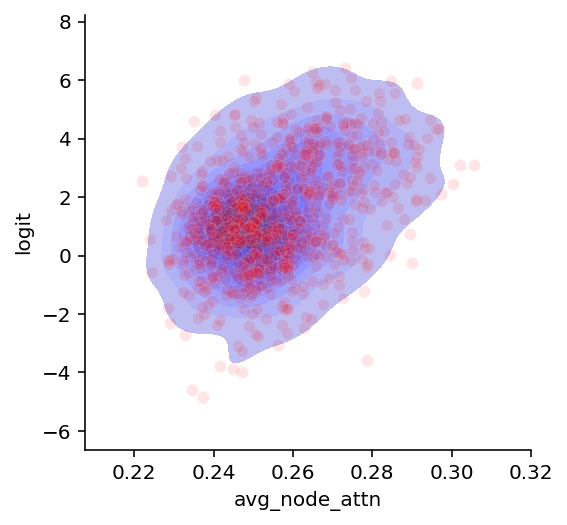

In [61]:
from nxviz.utils import node_table

g = graphs[0]
avg_node_attn = dict()
for idx, g in graphs.items():
    avg_node_attn[idx] = node_table(g)["attention"].mean()

node_attn_df = pd.DataFrame({
    "avg_node_attn": pd.Series(avg_node_attn),
    "logit": df["logit"]
})

fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(x="avg_node_attn", y="logit", data=node_attn_df, fill=True, color="blue")
sns.scatterplot(x="avg_node_attn", y="logit", data=node_attn_df, alpha=0.1, color="red")
sns.despine()

## Per graph, node entropy vs. attention

<AxesSubplot:xlabel='entropy', ylabel='attention'>

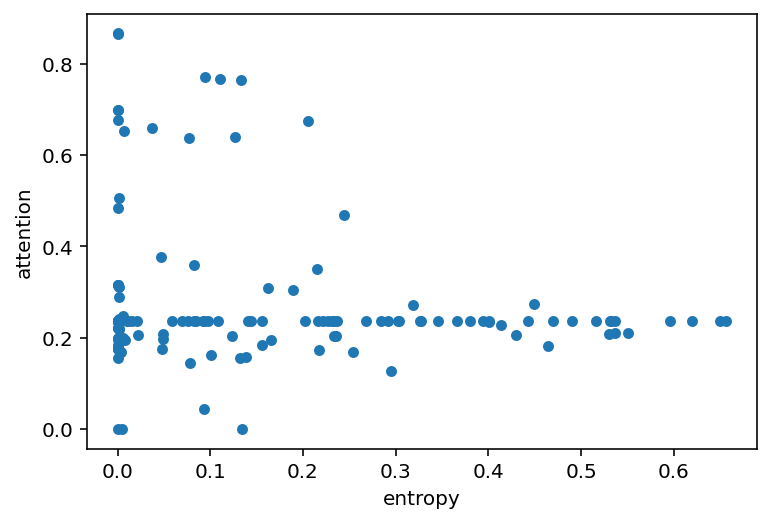

In [62]:
from nxviz.utils import node_table
g = graphs[highest_graphs.index[0]]
node_table(g).plot(kind="scatter", x="entropy", y="attention")

Not much of a relationship here.

<AxesSubplot:>

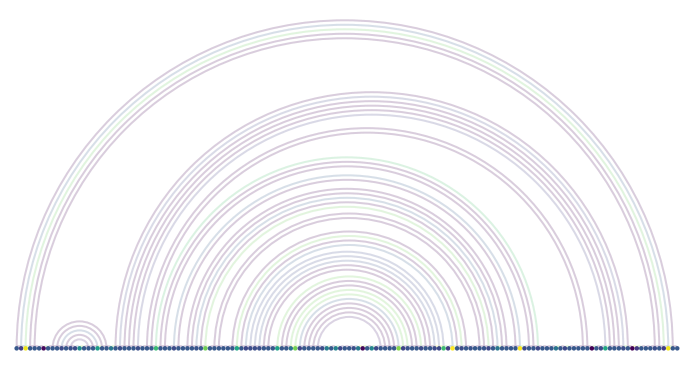

In [63]:
g = graphs[highest_graphs.index[1]]
nv.arc(g, node_color_by="attention", edge_color_by="attention")

## Arc Plot visualizations

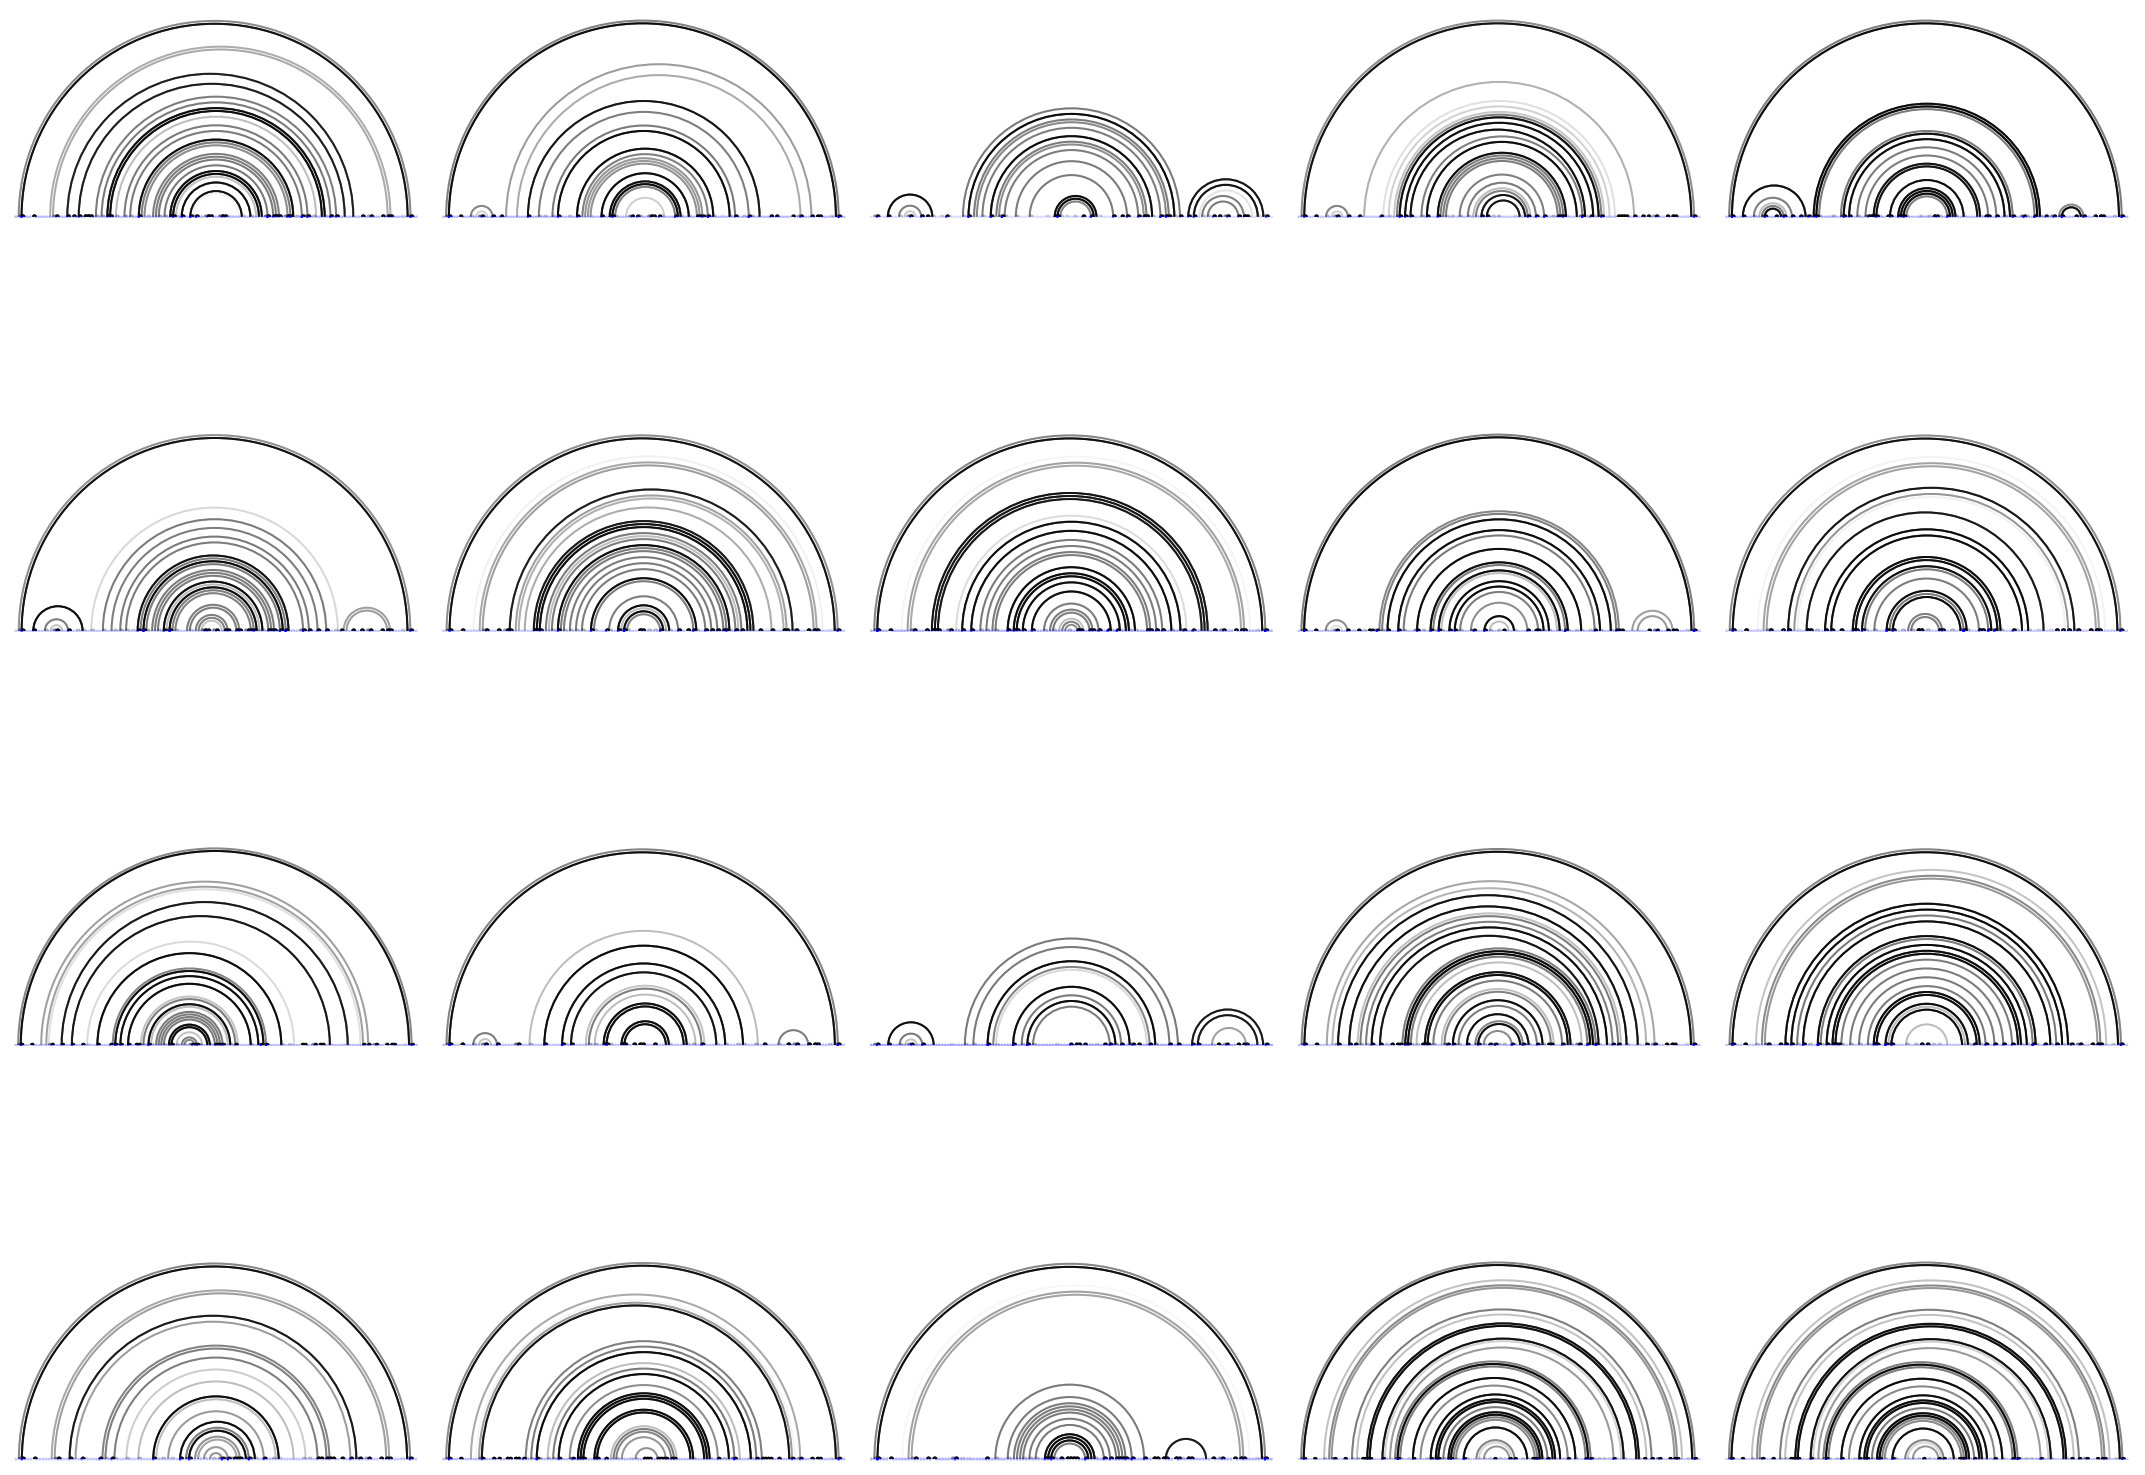

In [64]:

fig, ax = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
ax = ax.flatten()
for i, idx in enumerate(highest_graphs.index):
    g = graphs[idx]
    plt.sca(ax[i])
    nv.arc(g, node_alpha_by="attention", edge_alpha_by="attention")
    
for ax in ax[i+1:]:
    fig.delaxes(ax)
plt.tight_layout()

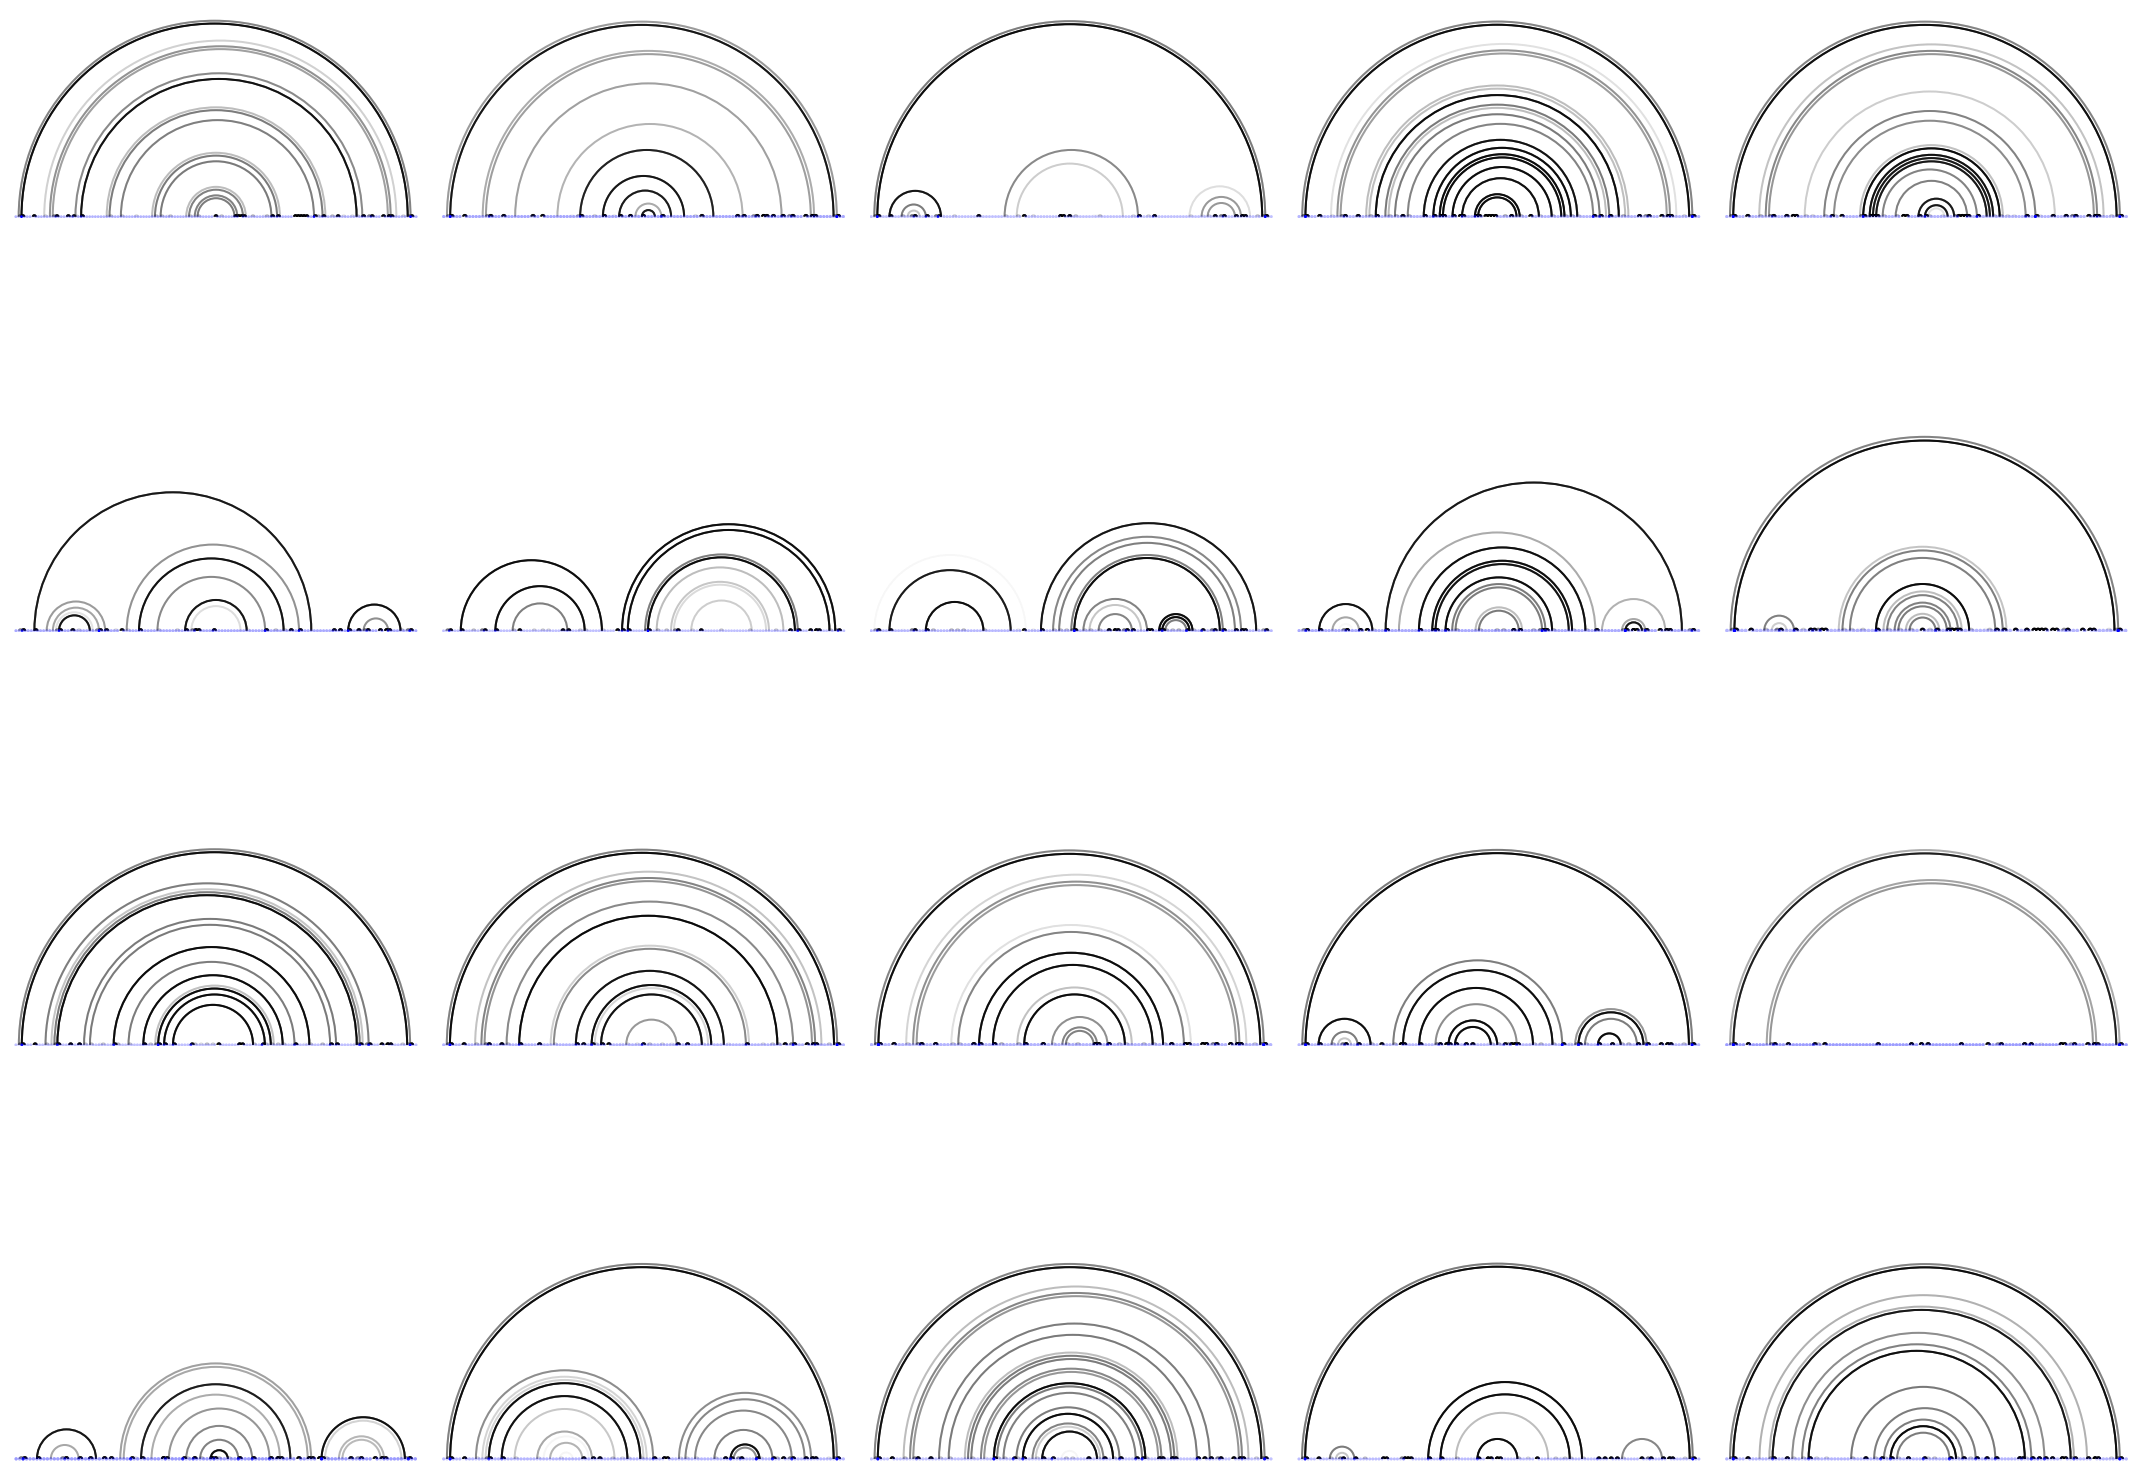

In [65]:
fig, ax = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
ax = ax.flatten()
for i, idx in enumerate(lowest_graphs.index):
    g = graphs[idx]
    plt.sca(ax[i])
    nv.arc(g, node_alpha_by="attention", edge_alpha_by="attention")
    
for ax in ax[i+1:]:
    fig.delaxes(ax)
plt.tight_layout()

## Baseline ML models

## Linear model on global properties of each RNA

In [66]:
linear_model_columns = ['avg_entropy', 'hairpin_score', 'minimum_free_energy', 'ensemble_free_energy']
X_trainr = df[linear_model_columns].loc[train_idxs]
X_testr = df[linear_model_columns].loc[test_idxs]


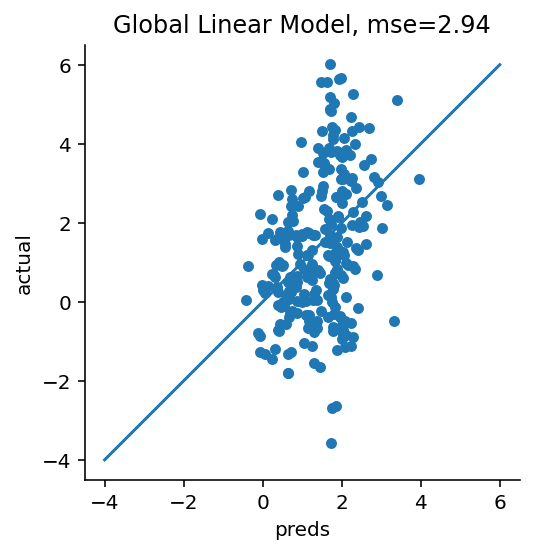

In [67]:
from sklearn.linear_model import LinearRegression

model_obj = LinearRegression()
model_obj.fit(X_trainr, y_train)
preds_linear = model_obj.predict(X_testr)

test_compare = pd.DataFrame({"preds": preds_linear.squeeze(), "actual": y_test.squeeze()})
test_compare.plot(kind="scatter", x="preds", y="actual")
plt.plot([-4, 6], [-4, 6])
plt.gca().set_aspect("equal")
plt.title(f"Global Linear Model, mse={mse(preds_linear, y_test):.2f}")
sns.despine()

## Random Forest on aligned entropy sequence

In [84]:
from drosha_gnn.data import interpolate, entropy_sequence, align_entropy

For entropy, the value `-1` is used for non-existent positions.
As such, we want to get any value that is not -1.

In [70]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 10))
# sns.heatmap(entropy_aligned_df, ax=axes)

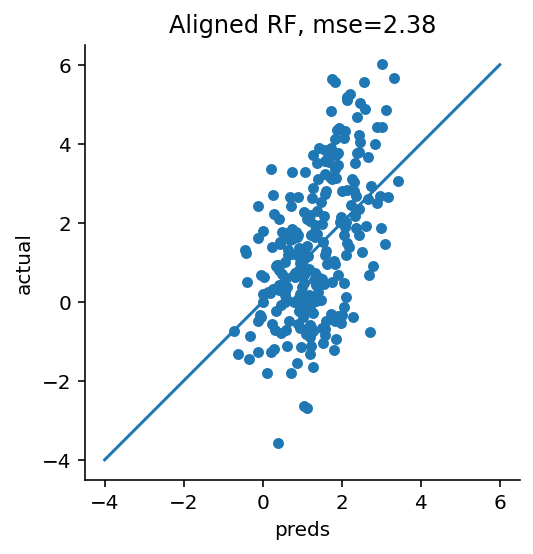

In [71]:
from sklearn.ensemble import RandomForestRegressor
X_trainr = entropy_aligned_df[entropy_columns].loc[train_idxs]
X_testr = entropy_aligned_df[entropy_columns].loc[test_idxs]

model_obj = RandomForestRegressor(n_estimators=300)
model_obj.fit(X_trainr, y_train.squeeze())
preds_rf = model_obj.predict(X_testr)

test_compare = pd.DataFrame({"preds": preds_rf.squeeze(), "actual": y_test.squeeze()})
test_compare.plot(kind="scatter", x="preds", y="actual")
plt.plot([-4, 6], [-4, 6])
plt.gca().set_aspect("equal")
plt.title(f"Aligned RF, mse={mse(preds_rf, y_test):.2f}")
sns.despine()

## Linear Model on aligned entropy columns

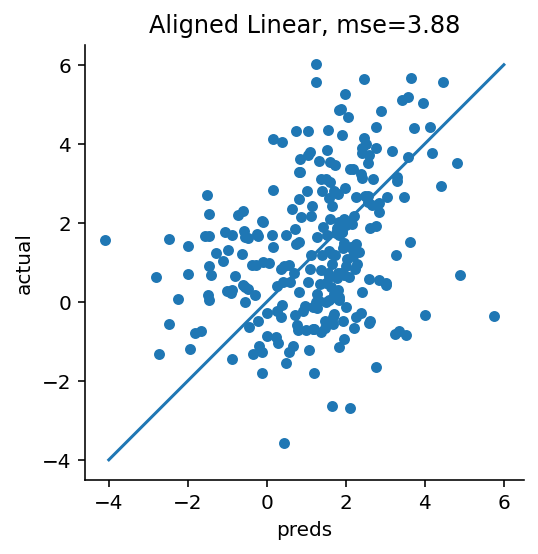

In [72]:
X_trainr = entropy_aligned_df[entropy_columns].loc[train_idxs]
X_testr = entropy_aligned_df[entropy_columns].loc[test_idxs]

model_objs = LinearRegression(normalize=True)
model_objs.fit(X_trainr, y_train.squeeze())
preds_linear = model_objs.predict(X_testr)

test_compare = pd.DataFrame({"preds": preds_linear.squeeze(), "actual": y_test.squeeze()})
test_compare.plot(kind="scatter", x="preds", y="actual")
plt.plot([-4, 6], [-4, 6])
plt.gca().set_aspect("equal")
plt.title(f"Aligned Linear, mse={mse(preds_linear, y_test):.2f}")
sns.despine()

## Infinitely Wide Neural Network on aligned entropy

In [73]:
from neural_tangents import stax as ntstax

## How many parameters exist in the model?

In [ ]:
from jax.tree_util import tree_map, tree_flatten

In [ ]:
tree_map(np.shape, opt_params)

In [ ]:
pos = nx.kamada_kawai_layout(g)
edge_width = np.array([d["attention"] for u, v, d in g.edges(data=True)]) * 20
node_size = np.array([d["attention"] for n, d in g.nodes(data=True)])**node_size_power * node_size_scale
nx.draw_networkx_nodes(g, pos, node_size=node_size)
nx.draw_networkx_edges(g, pos, width=edge_width)
ax = plt.gca()
ax.set_aspect("equal")
nv.plots.despine()

In [ ]:
nv.matrix(g, edge_aes_kwargs={"alpha_scale": 10})